In [1]:
import torch
import torch.nn as  nn
from models.involution import * 
from models.unet import * 
from models.unet_long import *
from dataset.dataset import *

## Cityscape dataset

In [16]:
import math
import numpy as np
import torch 
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim

from PIL import Image
import glob

import matplotlib.pyplot as plt
import os 
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import datetime
import logging

In [3]:
from utils.metrics import psnr
from utils.train_evalute import *

In [4]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
train_data_dir = "./dataset/foggy_cityscape/train"
test_data_dir = "./dataset/foggy_cityscape/test"
train_dataset = FoggyCityscape(train_data_dir, transform)
test_dataset = FoggyCityscape(test_data_dir, transform)

In [5]:
# Access an item from the dataset
index = 1  # Change this to test different images
haze_image, clear_image= train_dataset[index]

# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [6]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle=True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = batch_size,
                       num_workers = 4)

## Calculate GFLOPS and parameters

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(n_channels = 3)

epochs = 100
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# history = train_and_evaluate(model, train_loader, test_loader, criterion, 
#                              optimizer, epochs, device, train_log, val_log, batch_size)
print(model)

Unet(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (block_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (block_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (block_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (block_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [8]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(model.to(device), (3, 256, 256), 
                                          as_strings=True, print_per_layer_stat=False)

print(f"Flops of the model", flops)
print(f"Number of parameters", params)

Flops of the model 55.83 GMac
Number of parameters 31.38 M


In [9]:
log_dir = "logs/thay_long"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = os.path.join(log_dir, f"training_UNET_{timestamp}.log")
val_logfile = os.path.join(log_dir, f"val_UNET_{timestamp}.log")

def setup_logger(logger_name, log_file, level=logging.INFO):
    """Function to setup logger"""

    logger = logging.getLogger(logger_name)
    # Create a custom logger
    handler = logging.FileHandler(log_file)    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    handler.setFormatter(formatter)

    logger.setLevel(level)
    logger.addHandler(handler)
    
    return logger

train_log = setup_logger('train_log', log_file)
val_log = setup_logger('val_log', val_logfile)


In [10]:
history = train_and_evaluate(model, train_loader, test_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size)

Training Epoch 1/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 1/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.0272, Val Loss: 0.0217, PSNR: 16.8836669921875, SSIM: 0.6647618040442467
Model saved as weights/model_20240520_084928.pth


Training Epoch 2/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 2/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.0189, Val Loss: 0.0145, PSNR: 18.64771842956543, SSIM: 0.7223482158873717
Model saved as weights/model_20240520_084928.pth


Training Epoch 3/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 3/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.0151, Val Loss: 0.0126, PSNR: 19.23291778564453, SSIM: 0.7469739401761774
Model saved as weights/model_20240520_084928.pth


Training Epoch 4/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 4/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.0126, Val Loss: 0.0130, PSNR: 19.13040542602539, SSIM: 0.7629036003070352
Model saved as weights/model_20240520_084928.pth


Training Epoch 5/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 5/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.0115, Val Loss: 0.0103, PSNR: 20.107580184936523, SSIM: 0.7783657867480948
Model saved as weights/model_20240520_084928.pth


Training Epoch 6/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 6/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.0102, Val Loss: 0.0106, PSNR: 20.213350296020508, SSIM: 0.7927315665399217
Model saved as weights/model_20240520_084928.pth


Training Epoch 7/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 7/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.0096, Val Loss: 0.0083, PSNR: 21.103843688964844, SSIM: 0.8016837466683687
Model saved as weights/model_20240520_084928.pth


Training Epoch 8/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 8/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.0089, Val Loss: 0.0091, PSNR: 20.8433895111084, SSIM: 0.8033114007396224
Model saved as weights/model_20240520_084928.pth


Training Epoch 9/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 9/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.0083, Val Loss: 0.0094, PSNR: 20.659116744995117, SSIM: 0.8092437163775504
Model saved as weights/model_20240520_084928.pth


Training Epoch 10/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 10/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.0076, Val Loss: 0.0068, PSNR: 22.071943283081055, SSIM: 0.8230931939098848
Model saved as weights/model_20240520_084928.pth


Training Epoch 11/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 11/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.0070, Val Loss: 0.0077, PSNR: 21.4776668548584, SSIM: 0.817475597622819
Model saved as weights/model_20240520_084928.pth


Training Epoch 12/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 12/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.0065, Val Loss: 0.0063, PSNR: 22.39803123474121, SSIM: 0.8334039273374367
Model saved as weights/model_20240520_084928.pth


Training Epoch 13/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 13/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.0062, Val Loss: 0.0062, PSNR: 22.37272834777832, SSIM: 0.8320847575733175
Model saved as weights/model_20240520_084928.pth


Training Epoch 14/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 14/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.0056, Val Loss: 0.0059, PSNR: 22.688385009765625, SSIM: 0.8372864398656715
Model saved as weights/model_20240520_084928.pth


Training Epoch 15/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 15/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.0052, Val Loss: 0.0051, PSNR: 23.280595779418945, SSIM: 0.8461165839308844
Model saved as weights/model_20240520_084928.pth


Training Epoch 16/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 16/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.0045, Val Loss: 0.0058, PSNR: 22.68030548095703, SSIM: 0.8455902589241248
Model saved as weights/model_20240520_084928.pth


Training Epoch 17/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 17/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.0045, Val Loss: 0.0045, PSNR: 23.76282501220703, SSIM: 0.8570334320371064
Model saved as weights/model_20240520_084928.pth


Training Epoch 18/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 18/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.0042, Val Loss: 0.0053, PSNR: 23.088918685913086, SSIM: 0.8528011793085418
Model saved as weights/model_20240520_084928.pth


Training Epoch 19/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 19/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.0039, Val Loss: 0.0043, PSNR: 23.98631477355957, SSIM: 0.8613219680118311
Model saved as weights/model_20240520_084928.pth


Training Epoch 20/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 20/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.0037, Val Loss: 0.0051, PSNR: 23.171859741210938, SSIM: 0.8505424605146128
Model saved as weights/model_20240520_084928.pth


Training Epoch 21/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 21/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.0033, Val Loss: 0.0042, PSNR: 24.167570114135742, SSIM: 0.863746689213196
Model saved as weights/model_20240520_084928.pth


Training Epoch 22/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 22/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.0031, Val Loss: 0.0054, PSNR: 22.99106216430664, SSIM: 0.8546105704382452
Model saved as weights/model_20240520_084928.pth


Training Epoch 23/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 23/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.0029, Val Loss: 0.0039, PSNR: 24.52903938293457, SSIM: 0.8738736596485083
Model saved as weights/model_20240520_084928.pth


Training Epoch 24/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 24/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.0027, Val Loss: 0.0043, PSNR: 23.992029190063477, SSIM: 0.8653844140118954
Model saved as weights/model_20240520_084928.pth


Training Epoch 25/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 25/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.0028, Val Loss: 0.0036, PSNR: 24.79682159423828, SSIM: 0.8757193173959618
Model saved as weights/model_20240520_084928.pth


Training Epoch 26/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 26/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.0023, Val Loss: 0.0037, PSNR: 24.709083557128906, SSIM: 0.8777515185675072
Model saved as weights/model_20240520_084928.pth


Training Epoch 27/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 27/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.0026, Val Loss: 0.0033, PSNR: 25.1783447265625, SSIM: 0.8824010635311691
Model saved as weights/model_20240520_084928.pth


Training Epoch 28/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 28/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.0021, Val Loss: 0.0037, PSNR: 24.73954200744629, SSIM: 0.8800632327951062
Model saved as weights/model_20240520_084928.pth


Training Epoch 29/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 29/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 0.0020, Val Loss: 0.0031, PSNR: 25.42084503173828, SSIM: 0.8853073343244523
Model saved as weights/model_20240520_084928.pth


Training Epoch 30/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 30/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 0.0020, Val Loss: 0.0043, PSNR: 24.040735244750977, SSIM: 0.8733324756094922
Model saved as weights/model_20240520_084928.pth


Training Epoch 31/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 31/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 0.0018, Val Loss: 0.0032, PSNR: 25.30987548828125, SSIM: 0.887178228124586
Model saved as weights/model_20240520_084928.pth


Training Epoch 32/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 32/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 0.0018, Val Loss: 0.0036, PSNR: 24.75405502319336, SSIM: 0.8804739441000978
Model saved as weights/model_20240520_084928.pth


Training Epoch 33/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 33/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 0.0017, Val Loss: 0.0039, PSNR: 24.508045196533203, SSIM: 0.8830936547973394
Model saved as weights/model_20240520_084928.pth


Training Epoch 34/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 34/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 0.0016, Val Loss: 0.0029, PSNR: 25.689285278320312, SSIM: 0.8925493753549316
Model saved as weights/model_20240520_084928.pth


Training Epoch 35/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 35/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 0.0016, Val Loss: 0.0030, PSNR: 25.643518447875977, SSIM: 0.8926940339554043
Model saved as weights/model_20240520_084928.pth


Training Epoch 36/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 36/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 0.0014, Val Loss: 0.0029, PSNR: 25.803192138671875, SSIM: 0.8956960376098518
Model saved as weights/model_20240520_084928.pth


Training Epoch 37/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 37/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 0.0015, Val Loss: 0.0030, PSNR: 25.56378173828125, SSIM: 0.8927775976779573
Model saved as weights/model_20240520_084928.pth


Training Epoch 38/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 38/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 0.0019, Val Loss: 0.0030, PSNR: 25.649307250976562, SSIM: 0.8939366386276889
Model saved as weights/model_20240520_084928.pth


Training Epoch 39/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 39/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 0.0012, Val Loss: 0.0029, PSNR: 25.789596557617188, SSIM: 0.8954539805728727
Model saved as weights/model_20240520_084928.pth


Training Epoch 40/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 40/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 0.0011, Val Loss: 0.0027, PSNR: 25.988811492919922, SSIM: 0.8979824901173252
Model saved as weights/model_20240520_084928.pth


Training Epoch 41/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 41/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 41/100
Train Loss: 0.0011, Val Loss: 0.0031, PSNR: 25.43818473815918, SSIM: 0.8917585930040993
Model saved as weights/model_20240520_084928.pth


Training Epoch 42/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 42/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 42/100
Train Loss: 0.0012, Val Loss: 0.0031, PSNR: 25.574172973632812, SSIM: 0.8966909804581348
Model saved as weights/model_20240520_084928.pth


Training Epoch 43/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 43/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 43/100
Train Loss: 0.0014, Val Loss: 0.0027, PSNR: 26.070110321044922, SSIM: 0.8999066955522093
Model saved as weights/model_20240520_084928.pth


Training Epoch 44/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 44/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 44/100
Train Loss: 0.0011, Val Loss: 0.0030, PSNR: 25.7565860748291, SSIM: 0.8995123977592479
Model saved as weights/model_20240520_084928.pth


Training Epoch 45/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 45/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 45/100
Train Loss: 0.0010, Val Loss: 0.0028, PSNR: 25.923419952392578, SSIM: 0.9007431065458902
Model saved as weights/model_20240520_084928.pth


Training Epoch 46/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 46/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 46/100
Train Loss: 0.0010, Val Loss: 0.0031, PSNR: 25.5917911529541, SSIM: 0.8974368668975631
Model saved as weights/model_20240520_084928.pth


Training Epoch 47/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 47/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 47/100
Train Loss: 0.0010, Val Loss: 0.0028, PSNR: 25.997159957885742, SSIM: 0.9018402634802913
Model saved as weights/model_20240520_084928.pth


Training Epoch 48/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 48/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 48/100
Train Loss: 0.0010, Val Loss: 0.0033, PSNR: 25.16558837890625, SSIM: 0.8933994153329216
Model saved as weights/model_20240520_084928.pth


Training Epoch 49/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 49/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 49/100
Train Loss: 0.0010, Val Loss: 0.0028, PSNR: 25.94308090209961, SSIM: 0.9015344788188709
Model saved as weights/model_20240520_084928.pth


Training Epoch 50/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 50/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 50/100
Train Loss: 0.0009, Val Loss: 0.0027, PSNR: 26.158578872680664, SSIM: 0.9036209417887383
Model saved as weights/model_20240520_084928.pth


Training Epoch 51/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 51/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 51/100
Train Loss: 0.0009, Val Loss: 0.0027, PSNR: 26.05063247680664, SSIM: 0.9035074869609628
Model saved as weights/model_20240520_084928.pth


Training Epoch 52/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 52/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 52/100
Train Loss: 0.0009, Val Loss: 0.0027, PSNR: 26.12737464904785, SSIM: 0.9040521093454036
Model saved as weights/model_20240520_084928.pth


Training Epoch 53/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 53/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 53/100
Train Loss: 0.0009, Val Loss: 0.0027, PSNR: 26.032142639160156, SSIM: 0.9054966880622959
Model saved as weights/model_20240520_084928.pth


Training Epoch 54/100:   0%|          | 0/744 [00:00<?, ?it/s]

Validation Epoch 54/100:   0%|          | 0/382 [00:00<?, ?it/s]

Epoch 54/100
Train Loss: 0.0009, Val Loss: 0.0026, PSNR: 26.167020797729492, SSIM: 0.9052653664147666
Model saved as weights/model_20240520_084928.pth


Training Epoch 55/100:   0%|          | 0/744 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:24.748422622680664
SSIM: 0.8867105841636658


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:29.762615203857422
SSIM: 0.9344853758811951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:24.373737335205078
SSIM: 0.8188793063163757


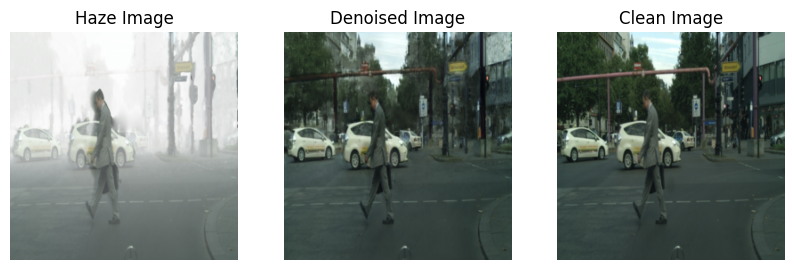

PSNR:25.941864013671875
SSIM: 0.9066181182861328


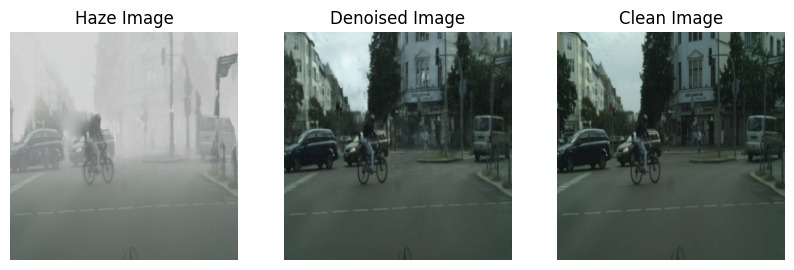

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:32.96982192993164
SSIM: 0.9448790550231934


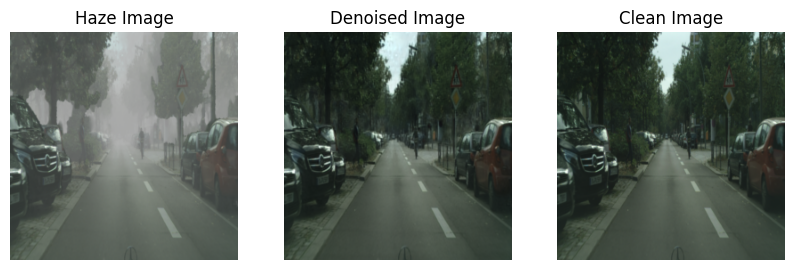

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:27.964664459228516
SSIM: 0.9156517386436462


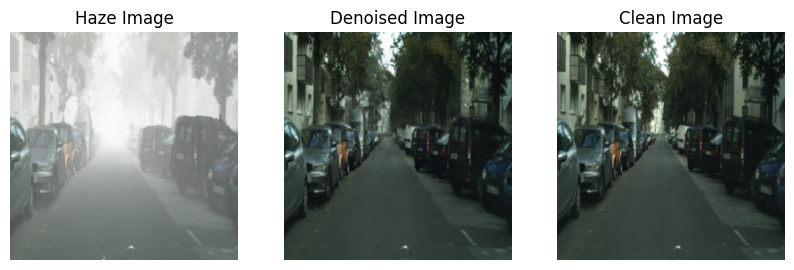

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:30.868223190307617
SSIM: 0.9409002661705017


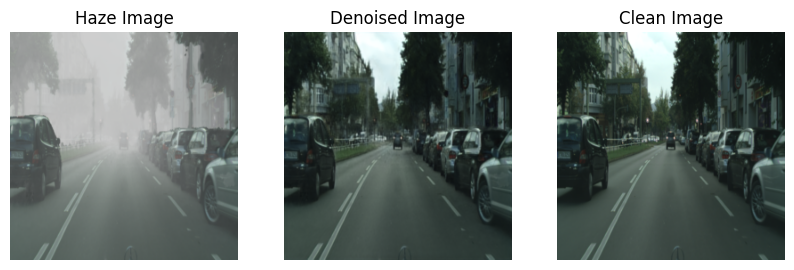

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:25.340213775634766
SSIM: 0.8705210089683533


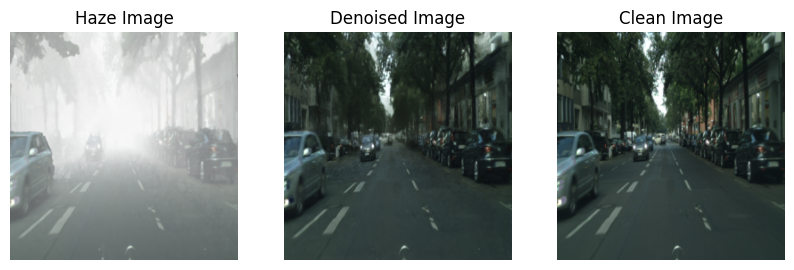

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:25.498497009277344
SSIM: 0.9028123021125793


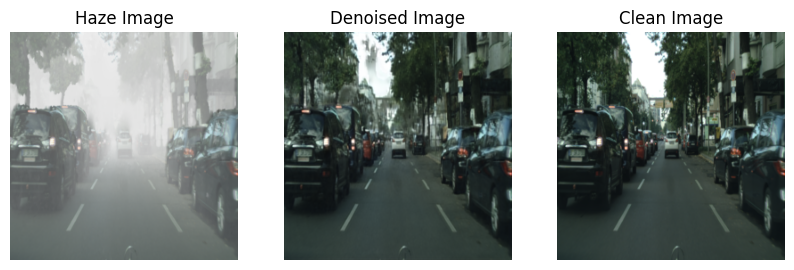

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:24.932947158813477
SSIM: 0.8866357803344727


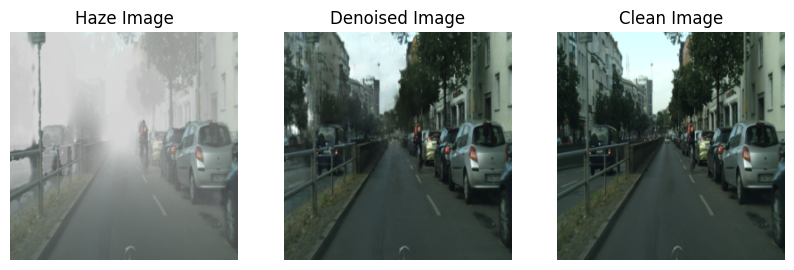

In [12]:
inference_lol(test_dataset, model, 
              model_path = "./weights/model_20240520_084928.pth", device = device)

## O Haze

In [13]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_dir = './dataset/O-HAZE/# O-HAZY NTIRE 2018'
ohaze_dataset = OHaze(dataset_dir, transform)

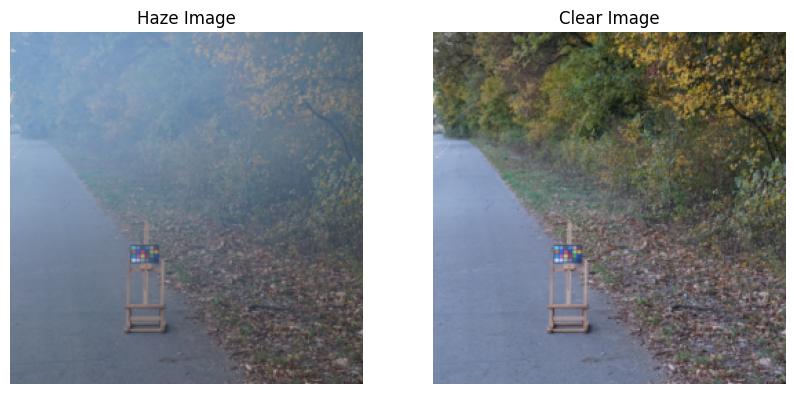

In [14]:
# Access an item from the dataset
index = 0  # Change this to test different images
haze_image, clear_image = ohaze_dataset[index]

# print(haze_image)
# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# Indices for splitting
total_size = len(ohaze_dataset)
indices = list(range(total_size))

# Split indices: 35 training, 5 validation, 5 test
train_indices, test_indices = train_test_split(indices, test_size=10, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=5, random_state=42)

print(f'Training indices: {len(train_indices)}')
print(f'Validation indices: {len(val_indices)}')
print(f'Test indices: {len(test_indices)}')

# Create Subset datasets
train_dataset = Subset(ohaze_dataset, train_indices)
val_dataset = Subset(ohaze_dataset, val_indices)
test_dataset = Subset(ohaze_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example usage
print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))



Training indices: 35
Validation indices: 5
Test indices: 5
Number of training samples: 9
Number of validation samples: 5
Number of test samples: 5


In [18]:
log_dir = "logs/thay_long"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = os.path.join(log_dir, f"training_UNET_OHAZE_{timestamp}.log")
val_logfile = os.path.join(log_dir, f"val_UNET__OHAZE_{timestamp}.log")

def setup_logger(logger_name, log_file, level=logging.INFO):
    """Function to setup logger"""

    logger = logging.getLogger(logger_name)
    # Create a custom logger
    handler = logging.FileHandler(log_file)    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    handler.setFormatter(formatter)

    logger.setLevel(level)
    logger.addHandler(handler)
    
    return logger

train_log = setup_logger('train_log', log_file)
val_log = setup_logger('val_log', val_logfile)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(n_channels = 3)
epochs = 100
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './weights/model_20240520_084928.pth'
model.to(device)
model.load_state_dict(torch.load(model_path))

history = train_and_evaluate(model, train_loader, val_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size = 1, fine_tune = 'OHAZE')

Training Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.0200, Val Loss: 0.0111, PSNR: 19.987985610961914, SSIM: 0.7365699410438538
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 2/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.0112, Val Loss: 0.0108, PSNR: 20.198678970336914, SSIM: 0.7517099142074585
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 3/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.0090, Val Loss: 0.0120, PSNR: 20.22291374206543, SSIM: 0.7678709030151367
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 4/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.0075, Val Loss: 0.0110, PSNR: 20.333051681518555, SSIM: 0.7857415437698364
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 5/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.0064, Val Loss: 0.0099, PSNR: 21.259872436523438, SSIM: 0.8023916959762574
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 6/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.0055, Val Loss: 0.0103, PSNR: 21.21607780456543, SSIM: 0.8094250321388244
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 7/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.0048, Val Loss: 0.0098, PSNR: 21.291614532470703, SSIM: 0.8199445486068726
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 8/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.0042, Val Loss: 0.0097, PSNR: 21.529067993164062, SSIM: 0.8276338338851928
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 9/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.0036, Val Loss: 0.0098, PSNR: 21.47017478942871, SSIM: 0.828166663646698
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 10/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.0032, Val Loss: 0.0099, PSNR: 21.412580490112305, SSIM: 0.8310378432273865
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 11/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.0032, Val Loss: 0.0114, PSNR: 21.1162109375, SSIM: 0.8241978406906127
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 12/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.0029, Val Loss: 0.0111, PSNR: 21.007080078125, SSIM: 0.8261376023292542
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 13/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.0028, Val Loss: 0.0098, PSNR: 21.57502555847168, SSIM: 0.8368714451789856
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 14/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.0027, Val Loss: 0.0089, PSNR: 21.365768432617188, SSIM: 0.8476405143737793
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 15/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.0024, Val Loss: 0.0099, PSNR: 21.558889389038086, SSIM: 0.8396347045898438
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 16/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.0022, Val Loss: 0.0092, PSNR: 21.734556198120117, SSIM: 0.8444501399993897
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 17/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.0021, Val Loss: 0.0094, PSNR: 21.59571647644043, SSIM: 0.8446334004402161
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 18/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.0020, Val Loss: 0.0091, PSNR: 21.635446548461914, SSIM: 0.8485486149787903
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 19/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.0019, Val Loss: 0.0094, PSNR: 21.434370040893555, SSIM: 0.8483591556549073
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 20/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.0017, Val Loss: 0.0095, PSNR: 21.47117805480957, SSIM: 0.8485158920288086
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 21/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.0017, Val Loss: 0.0101, PSNR: 21.330110549926758, SSIM: 0.8453680515289307
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 22/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.0016, Val Loss: 0.0104, PSNR: 21.415929794311523, SSIM: 0.8421075940132141
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 23/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.0016, Val Loss: 0.0097, PSNR: 21.34747886657715, SSIM: 0.8489999413490296
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 24/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.0016, Val Loss: 0.0097, PSNR: 21.59500503540039, SSIM: 0.8488409519195557
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 25/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.0017, Val Loss: 0.0097, PSNR: 21.425832748413086, SSIM: 0.8490943431854248
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 26/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.0019, Val Loss: 0.0100, PSNR: 21.17225456237793, SSIM: 0.8464881658554078
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 27/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.0017, Val Loss: 0.0094, PSNR: 21.604080200195312, SSIM: 0.8530871510505676
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 28/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.0017, Val Loss: 0.0098, PSNR: 21.609159469604492, SSIM: 0.8503344297409058
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 29/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 0.0015, Val Loss: 0.0097, PSNR: 21.4228572845459, SSIM: 0.850390899181366
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 30/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 0.0016, Val Loss: 0.0090, PSNR: 21.643543243408203, SSIM: 0.8561485409736633
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 31/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 0.0015, Val Loss: 0.0094, PSNR: 21.61182975769043, SSIM: 0.8519230842590332
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 32/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 0.0014, Val Loss: 0.0093, PSNR: 21.534198760986328, SSIM: 0.8536815881729126
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 33/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 0.0013, Val Loss: 0.0092, PSNR: 21.638778686523438, SSIM: 0.8549557089805603
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 34/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 0.0012, Val Loss: 0.0091, PSNR: 21.65685272216797, SSIM: 0.8554883480072022
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 35/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 0.0012, Val Loss: 0.0092, PSNR: 21.6866512298584, SSIM: 0.8554441332817078
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 36/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 0.0012, Val Loss: 0.0088, PSNR: 21.661535263061523, SSIM: 0.8597046613693238
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 37/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 0.0011, Val Loss: 0.0092, PSNR: 21.668615341186523, SSIM: 0.8552141427993775
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 38/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 0.0011, Val Loss: 0.0093, PSNR: 21.626829147338867, SSIM: 0.8553751111030579
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 39/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 0.0011, Val Loss: 0.0092, PSNR: 21.514318466186523, SSIM: 0.8581407904624939
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 40/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 0.0012, Val Loss: 0.0088, PSNR: 21.678224563598633, SSIM: 0.8598745584487915
Model saved as weights/model_OHAZE_20240520_094731.pth


Training Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
valid_per_epoch(model, test_loader, criterion, device, 0, 
                    100, val_log, batch_size = 1, display = False)

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

(0.009478179179131985, tensor(20.5062, device='cuda:0'), 0.8120293974876404)

## Dense Haze

In [26]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_dir = './dataset/Dense-HAZE/'
dhaze_dataset = DenseHaze(dataset_dir, transform)

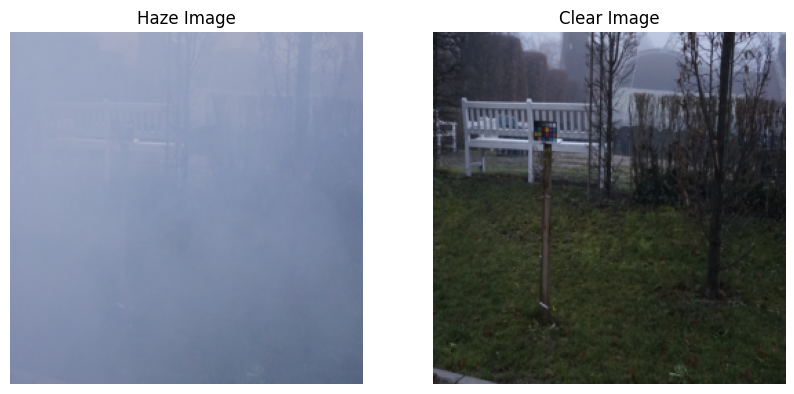

In [27]:
# Access an item from the dataset
index = 0  # Change this to test different images
haze_image, clear_image = dhaze_dataset[index]

# print(haze_image)
# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [28]:
from sklearn.model_selection import train_test_split

# Indices for splitting
total_size = len(dhaze_dataset)
indices = list(range(total_size))

# Split indices: 45 training, 5 validation, 5 test
train_indices, test_indices = train_test_split(indices, test_size=10, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=5, random_state=42)

print(f'Training indices: {len(train_indices)}')
print(f'Validation indices: {len(val_indices)}')
print(f'Test indices: {len(test_indices)}')

# Create Subset datasets
train_dataset = Subset(dhaze_dataset, train_indices)
val_dataset = Subset(dhaze_dataset, val_indices)
test_dataset = Subset(dhaze_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example usage
print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))



Training indices: 45
Validation indices: 5
Test indices: 5
Number of training samples: 12
Number of validation samples: 5
Number of test samples: 5


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(n_channels = 3)
epochs = 100
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './weights/model_20240520_084928.pth'
model.to(device)
model.load_state_dict(torch.load(model_path))

history = train_and_evaluate(model, train_loader, val_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size = 1, fine_tune = 'DHAZE')

Training Epoch 1/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.0466, Val Loss: 0.0323, PSNR: 15.116853713989258, SSIM: 0.4035621464252472
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 2/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 2/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.0384, Val Loss: 0.0299, PSNR: 15.473563194274902, SSIM: 0.4401535987854004
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 3/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 3/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.0336, Val Loss: 0.0297, PSNR: 15.652650833129883, SSIM: 0.46674802899360657
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 4/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 4/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.0287, Val Loss: 0.0297, PSNR: 15.478647232055664, SSIM: 0.4996239483356476
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 5/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 5/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.0249, Val Loss: 0.0263, PSNR: 16.061199188232422, SSIM: 0.5260000705718995
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 6/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 6/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.0208, Val Loss: 0.0299, PSNR: 15.755202293395996, SSIM: 0.5142407596111298
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 7/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 7/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.0225, Val Loss: 0.0229, PSNR: 16.52572250366211, SSIM: 0.5609288036823272
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 8/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 8/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.0211, Val Loss: 0.0333, PSNR: 15.491233825683594, SSIM: 0.524010056257248
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 9/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 9/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.0195, Val Loss: 0.0241, PSNR: 16.559917449951172, SSIM: 0.5567328572273255
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 10/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 10/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.0195, Val Loss: 0.0259, PSNR: 16.117002487182617, SSIM: 0.5573571681976318
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 11/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 11/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.0174, Val Loss: 0.0238, PSNR: 16.548099517822266, SSIM: 0.5728919088840485
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 12/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 12/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.0161, Val Loss: 0.0287, PSNR: 15.9263334274292, SSIM: 0.5554913520812989
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 13/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 13/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.0137, Val Loss: 0.0264, PSNR: 16.288951873779297, SSIM: 0.5592775583267212
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 14/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 14/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.0126, Val Loss: 0.0259, PSNR: 16.007923126220703, SSIM: 0.5724989533424377
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 15/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 15/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.0127, Val Loss: 0.0260, PSNR: 16.34697151184082, SSIM: 0.5612051486968994
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 16/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 16/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.0112, Val Loss: 0.0282, PSNR: 15.916800498962402, SSIM: 0.5710289776325226
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 17/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 17/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.0105, Val Loss: 0.0248, PSNR: 16.317949295043945, SSIM: 0.5794619500637055
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 18/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 18/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.0096, Val Loss: 0.0222, PSNR: 16.79205322265625, SSIM: 0.5918596863746644
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 19/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 19/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.0093, Val Loss: 0.0257, PSNR: 16.287681579589844, SSIM: 0.5782851457595826
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 20/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 20/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.0093, Val Loss: 0.0241, PSNR: 16.551712036132812, SSIM: 0.5877639055252075
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 21/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 21/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.0085, Val Loss: 0.0260, PSNR: 16.306533813476562, SSIM: 0.5841251671314239
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 22/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 22/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.0078, Val Loss: 0.0263, PSNR: 16.164424896240234, SSIM: 0.5857732713222503
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 23/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 23/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.0072, Val Loss: 0.0240, PSNR: 16.530569076538086, SSIM: 0.5939880847930908
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 24/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 24/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.0072, Val Loss: 0.0243, PSNR: 16.466054916381836, SSIM: 0.594729620218277
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 25/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 25/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.0066, Val Loss: 0.0252, PSNR: 16.411741256713867, SSIM: 0.5953719973564148
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 26/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 26/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.0065, Val Loss: 0.0238, PSNR: 16.595216751098633, SSIM: 0.59569091796875
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 27/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 27/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.0061, Val Loss: 0.0257, PSNR: 16.266315460205078, SSIM: 0.5946706533432007
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 28/100:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 28/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.0060, Val Loss: 0.0232, PSNR: 16.726781845092773, SSIM: 0.6028035759925843
Model saved as weights/model_DHAZE_20240520_100923.pth


Training Epoch 29/100:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
valid_per_epoch(model, test_loader, criterion, device, 0, 
                    100, val_log, batch_size = 1, display = False)

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

(0.031026415154337884, tensor(15.3788, device='cuda:0'), 0.5621113538742065)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:13.067337036132812
SSIM: 0.5912928581237793


PSNR:14.473942756652832
SSIM: 0.5336503386497498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


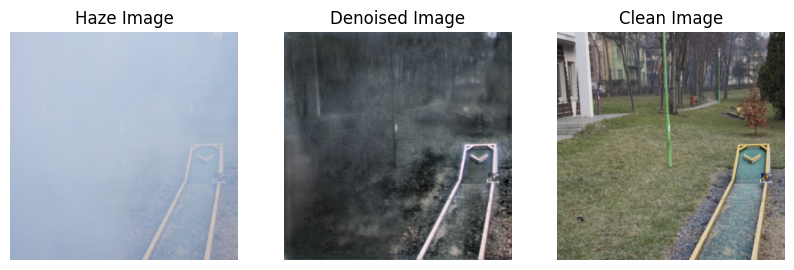

PSNR:14.650138854980469
SSIM: 0.44735729694366455


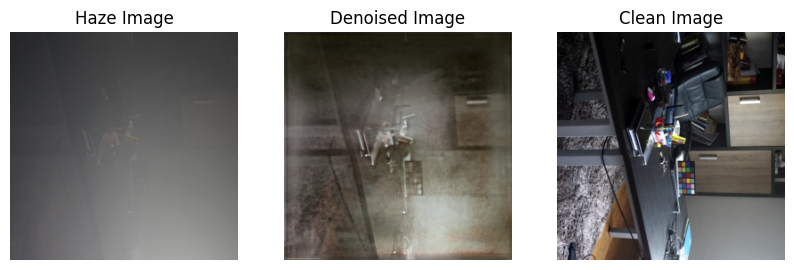

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:16.83700180053711
SSIM: 0.6747663021087646


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:17.420682907104492
SSIM: 0.5537617802619934


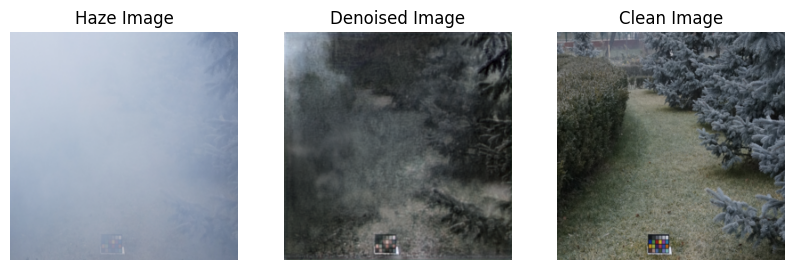

IndexError: list index out of range

In [31]:
inference_lol(test_dataset, model, 
              model_path = "./weights/model_DHAZE_20240520_100923.pth", device = device)

## NH Haze

In [33]:
class NHHaze(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        # self.haze_dir = os.path.join(data_dir, "hazy")
        # self.clean_dir = os.path.join(data_dir, "GT")

        self.haze_images = []
        self.clean_images = []
        for filename in os.listdir(self.data_dir):
            if filename.endswith("_hazy.png"):
                self.haze_images.append(filename)
            elif filename.endswith("_GT.png"):
                self.clean_images.append(filename)
        
        self.haze_images.sort()
        self.clean_images.sort()

        # print(self.haze_images)
        # print(self.clean_images)
        # Error handling if number of haze and clear images don't match
        if len(self.haze_images) != len(self.clean_images):
            raise ValueError("Number of haze images does not match number of clear images.")

    def __len__(self):
        return len(self.haze_images)

    def __getitem__(self, idx):
        haze_image_name = self.haze_images[idx]
        clean_image_name = self.clean_images[idx]
        haze_image_path = os.path.join(self.data_dir, haze_image_name)
        clean_image_path = os.path.join(self.data_dir, clean_image_name)

 
        haze_image = Image.open(haze_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            haze_image = self.transform(haze_image)
            clean_image = self.transform(clean_image)

        return haze_image, clean_image

# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_dir = './dataset/NH-HAZE/NH-HAZE'
nhhaze_dataset = NHHaze(dataset_dir, transform)

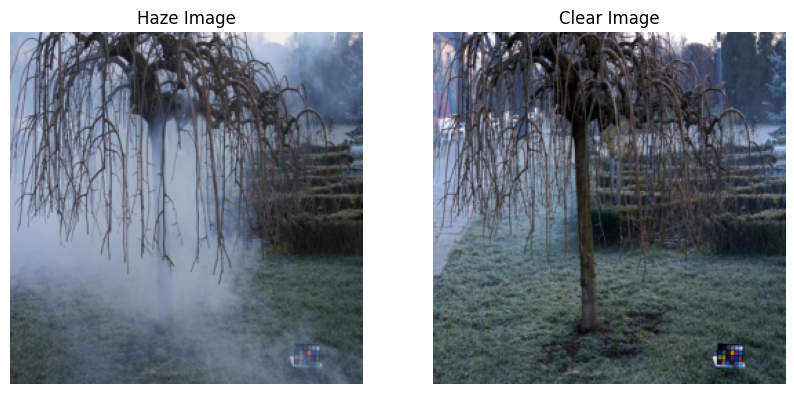

In [34]:
# Access an item from the dataset
index = 1  # Change this to test different images
haze_image, clear_image = nhhaze_dataset[index]

# print(haze_image)
# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [35]:
from sklearn.model_selection import train_test_split

# Indices for splitting
total_size = len(nhhaze_dataset)
indices = list(range(total_size))

# Split indices: 45 training, 5 validation, 5 test
train_indices, test_indices = train_test_split(indices, test_size=10, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=5, random_state=42)

print(f'Training indices: {len(train_indices)}')
print(f'Validation indices: {len(val_indices)}')
print(f'Test indices: {len(test_indices)}')

# Create Subset datasets
train_dataset = Subset(nhhaze_dataset, train_indices)
val_dataset = Subset(nhhaze_dataset, val_indices)
test_dataset = Subset(nhhaze_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example usage
print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))



Training indices: 45
Validation indices: 5
Test indices: 5
Number of training samples: 9
Number of validation samples: 5
Number of test samples: 5


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(n_channels = 3)
epochs = 100
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './weights/model_20240520_084928.pth'
model.to(device)
model.load_state_dict(torch.load(model_path))

history = train_and_evaluate(model, train_loader, val_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size = 1, fine_tune = 'NHHAZE')

Training Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.0451, Val Loss: 0.0309, PSNR: 15.338556289672852, SSIM: 0.5183402061462402
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 2/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.0317, Val Loss: 0.0335, PSNR: 15.5034818649292, SSIM: 0.5321216344833374
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 3/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.0274, Val Loss: 0.0352, PSNR: 15.393091201782227, SSIM: 0.5476971983909606
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 4/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.0244, Val Loss: 0.0262, PSNR: 16.074731826782227, SSIM: 0.5865449607372284
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 5/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.0204, Val Loss: 0.0316, PSNR: 16.019163131713867, SSIM: 0.5849093854427337
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 6/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.0185, Val Loss: 0.0332, PSNR: 15.719586372375488, SSIM: 0.5916574418544769
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 7/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.0168, Val Loss: 0.0296, PSNR: 16.289012908935547, SSIM: 0.5998185098171234
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 8/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.0142, Val Loss: 0.0294, PSNR: 15.637054443359375, SSIM: 0.6137990117073059
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 9/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.0127, Val Loss: 0.0292, PSNR: 15.9671630859375, SSIM: 0.615950071811676
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 10/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.0108, Val Loss: 0.0287, PSNR: 16.137956619262695, SSIM: 0.6178456783294678
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 11/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.0094, Val Loss: 0.0291, PSNR: 16.115060806274414, SSIM: 0.6194146752357483
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 12/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.0084, Val Loss: 0.0302, PSNR: 16.050649642944336, SSIM: 0.6209333419799805
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 13/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.0079, Val Loss: 0.0291, PSNR: 15.935646057128906, SSIM: 0.6255273699760437
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 14/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.0074, Val Loss: 0.0297, PSNR: 16.00859260559082, SSIM: 0.6240841627120972
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 15/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.0068, Val Loss: 0.0291, PSNR: 16.09510612487793, SSIM: 0.6261126875877381
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 16/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.0065, Val Loss: 0.0306, PSNR: 15.93644905090332, SSIM: 0.6223550081253052
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 17/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.0061, Val Loss: 0.0311, PSNR: 16.043315887451172, SSIM: 0.6234597325325012
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 18/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.0061, Val Loss: 0.0309, PSNR: 16.022947311401367, SSIM: 0.6253001928329468
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 19/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.0057, Val Loss: 0.0281, PSNR: 16.069456100463867, SSIM: 0.6315747618675231
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 20/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.0057, Val Loss: 0.0272, PSNR: 16.18859100341797, SSIM: 0.6365740299224854
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 21/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.0055, Val Loss: 0.0270, PSNR: 16.265676498413086, SSIM: 0.6378159165382385
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 22/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.0053, Val Loss: 0.0292, PSNR: 16.052270889282227, SSIM: 0.6331043243408203
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 23/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.0052, Val Loss: 0.0313, PSNR: 16.047788619995117, SSIM: 0.6278461694717408
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 24/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.0050, Val Loss: 0.0287, PSNR: 16.134292602539062, SSIM: 0.6336672902107239
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 25/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.0049, Val Loss: 0.0296, PSNR: 16.082162857055664, SSIM: 0.6319823861122131
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 26/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.0048, Val Loss: 0.0297, PSNR: 16.07655906677246, SSIM: 0.6350135207176208
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 27/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.0048, Val Loss: 0.0285, PSNR: 16.230379104614258, SSIM: 0.6376203536987305
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 28/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.0046, Val Loss: 0.0304, PSNR: 16.01883316040039, SSIM: 0.6277367830276489
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 29/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 0.0044, Val Loss: 0.0290, PSNR: 16.167821884155273, SSIM: 0.6395325422286987
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 30/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 0.0043, Val Loss: 0.0278, PSNR: 16.268178939819336, SSIM: 0.6394229888916015
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 31/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 0.0042, Val Loss: 0.0283, PSNR: 16.275400161743164, SSIM: 0.6392813324928284
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 32/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 0.0040, Val Loss: 0.0277, PSNR: 16.239471435546875, SSIM: 0.6421425938606262
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 33/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 0.0039, Val Loss: 0.0285, PSNR: 16.31125831604004, SSIM: 0.6391341328620911
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 34/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 0.0039, Val Loss: 0.0286, PSNR: 16.215726852416992, SSIM: 0.6374722361564636
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 35/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 0.0041, Val Loss: 0.0275, PSNR: 16.245502471923828, SSIM: 0.6441950559616089
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 36/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 0.0041, Val Loss: 0.0262, PSNR: 16.316808700561523, SSIM: 0.6479349851608276
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 37/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 0.0040, Val Loss: 0.0279, PSNR: 16.212705612182617, SSIM: 0.6407290458679199
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 38/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 0.0038, Val Loss: 0.0267, PSNR: 16.465133666992188, SSIM: 0.6478857636451721
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 39/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 0.0037, Val Loss: 0.0288, PSNR: 16.17474937438965, SSIM: 0.6389049530029297
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 40/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 0.0035, Val Loss: 0.0284, PSNR: 16.4058895111084, SSIM: 0.6428015112876893
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 41/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/100
Train Loss: 0.0034, Val Loss: 0.0290, PSNR: 16.179176330566406, SSIM: 0.6387096166610717
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 42/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/100
Train Loss: 0.0033, Val Loss: 0.0278, PSNR: 16.394865036010742, SSIM: 0.6453522086143494
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 43/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/100
Train Loss: 0.0032, Val Loss: 0.0278, PSNR: 16.361690521240234, SSIM: 0.6447620153427124
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 44/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/100
Train Loss: 0.0031, Val Loss: 0.0282, PSNR: 16.38496208190918, SSIM: 0.6444082260131836
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 45/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/100
Train Loss: 0.0030, Val Loss: 0.0280, PSNR: 16.27958869934082, SSIM: 0.6445840120315551
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 46/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/100
Train Loss: 0.0030, Val Loss: 0.0279, PSNR: 16.384815216064453, SSIM: 0.6449034690856934
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 47/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/100
Train Loss: 0.0029, Val Loss: 0.0286, PSNR: 16.36525535583496, SSIM: 0.6441609859466553
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 48/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/100
Train Loss: 0.0029, Val Loss: 0.0286, PSNR: 16.238574981689453, SSIM: 0.6425412416458129
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 49/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/100
Train Loss: 0.0029, Val Loss: 0.0284, PSNR: 16.33292007446289, SSIM: 0.6448124766349792
Model saved as weights/model_NHHAZE_20240520_102932.pth


Training Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
valid_per_epoch(model, test_loader, criterion, device, 0, 
                    100, val_log, batch_size = 1, display = False)

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

(0.04139421097934246, tensor(14.2338, device='cuda:0'), 0.6036907196044922)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:11.256994247436523
SSIM: 0.5349374413490295


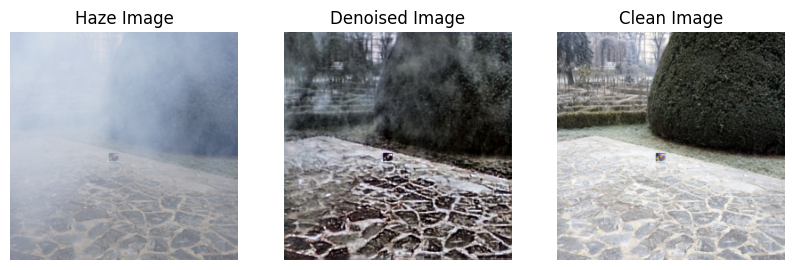

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:13.313262939453125
SSIM: 0.6267557144165039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:14.485313415527344
SSIM: 0.5607422590255737


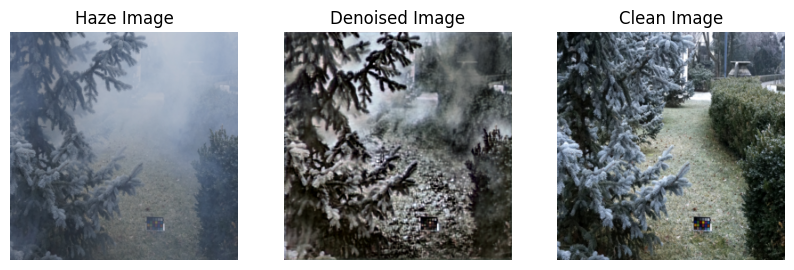

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:16.520355224609375
SSIM: 0.6472071409225464


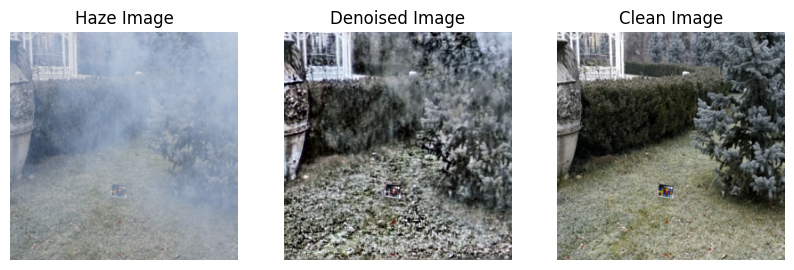

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:15.592900276184082
SSIM: 0.6488110423088074


IndexError: list index out of range

In [39]:
inference_lol(test_dataset, model, 
              model_path = "./weights/model_DHAZE_20240520_100923.pth", device = device)

In [43]:
### Testing Involution normal

In [44]:
import torch
import torch.nn as nn
import involution_cuda 
from torch.autograd import Function
import torch.nn.functional as F
from torch.nn.modules.utils import _pair

class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 use_bn = True, use_act = True, 
                 stride = 1, padding = 0, dilation = 1):
        super().__init__()

        self.kernel_size = kernel_size
        self.use_bn = use_bn
        self.use_act = use_act

        if self.use_bn:
            self.batch_norm = nn.BatchNorm2d(out_channels)

        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                 stride = stride, padding = padding, dilation = dilation)
        
    def forward(self, x):
        x = self.conv2d(x)

        if self.use_bn:
            x = self.batch_norm(x)
        
        if self.use_act:
            x = F.relu(x)

        return x


In [47]:
class Involution(nn.Module):
    def __init__(self, channels, kernel_size, stride):
        super(Involution, self).__init__()
        self.kernel_size = kernel_size
        self.channels = channels
        self.stride = stride

        reduction_ratio = 4
        self.group_channels = 16
        self.groups = channels // self.group_channels

        self.conv1 = ConvModule(in_channels = channels,
                                out_channels = channels // reduction_ratio,
                                kernel_size = 1)
        
        self.conv2 = ConvModule(in_channels = channels // reduction_ratio,
                                out_channels = kernel_size ** 2 * self.groups,
                                kernel_size = 1,
                                stride = 1,
                                use_act = False,
                                use_bn = False)
        
        if stride > 1:
            self.avgpool = nn.AvgPool2d(stride, stride)

        self.unfold = nn.Unfold(kernel_size, 1, (kernel_size-1)//2, stride)

    def forward(self, x):
        weight = self.conv2(self.conv1(x if self.stride == 1 else self.avgpool(x)))
        b, c, h, w = weight.shape
        weight = weight.view(b, self.groups, self.kernel_size**2, h, w).unsqueeze(2)
        out = self.unfold(x).view(b, self.groups, self.group_channels, self.kernel_size**2, h, w)
        out = (weight * out).sum(dim=3).view(b, self.channels, h, w)
        return out

In [50]:
involution = Involution(channels = 64, kernel_size = 7, stride = 1).to(device)

x = torch.randn(1, 64, 256, 256).to(device)
involution(x).shape

torch.Size([1, 64, 256, 256])